In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [17]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [5]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [6]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    return (lp + ll)

In [7]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

In [8]:
def hRatio(theta0,theta1,flux, times, fluxErr):
    """
    Calculates the ratio between the log probabilities of theta0 and theta1
    
    Args:
        theta0 (list) - parameters of the model
        theta1 (list) - parameters of the model
        flux (list) - list of flux values
        times (list) - list of times
        fluxErr (list) - list of errors for the corresponding fluxes
    Returns: 
        ratio (float) - ratio of the log probabilities of theta0 and theta1
    """
    lnProb0 = logProbability(theta0, times, flux, fluxErr)
    lnProb1 = logProbability(theta1,times,flux,fluxErr)
    ratio = np.exp(lnProb1 - lnProb0)
    return ratio

In [9]:
def proposeJump(theta, cov):
    """
    Chooses new parameters for the model using a normal distribution
    
    Args:
        theta (list) - parameters for the model
        cov (list) - standard deviations of the normal distributions to choose new values from
    Returns:
        newTheta (list) - new parameters for the model
    """
    xdim, ydim, velocity, tRef, opacity = theta
    newXDim = np.random.normal(xdim, cov[0])
    newYDim = np.random.normal(ydim, cov[1])
    newVelocity = np.random.normal(velocity,cov[2])
    newTRef = np.random.normal(tRef,cov[3])
    newOpacity = np.random.normal(opacity, cov[4])
    newTheta = (newXDim,newYDim,  newVelocity, newTRef, newOpacity)
    return newTheta

In [10]:
def mhMcmc(theta0, cov, steps, times, flux, fluxErr):
    """
    Runs a Metripolitan-Hastings MCMC Sampler
    
    Args:
        theta0 (list) - initial parameters for the model
        cov (list) - standard deviations of the normal distributions to choose new values from
        steps (int) - number of samples to take
        times (list) - array of time values
        flux (list) - array of flux values
        fluxErr (list) - array of errors for the corresponding flux values
    Returns:
        positions (list) - list of the current parameters for the model after eachs sample
        lnProbPos (list) - list of the current log probability after each sampler
        acceptanceRatio (list) - percentage of samples that were accepted after each sample
    """
    positions = np.zeros((steps+1,len(theta0)))##Initialize the arrays
    lnProbPos = -np.inf*np.ones(steps+1)
    acceptanceRatio = np.zeros_like(lnProbPos)
    accepted = 0
    
    positions[0] = [theta0[0],theta0[1],theta0[2],theta0[3],theta0[4]]##Set the initial model parameters 
    lnProbPos [0] = logProbability(theta0, times, flux, fluxErr)##and log probability
    
    for step in np.arange(1,steps+1):
        proposal = proposeJump(positions[step -1],cov)##Propose new parameters
        lnProb0 = lnProbPos[step-1]
        lnProb1 = logProbability([proposal[0],proposal[1],proposal[2],proposal[3],proposal[4]],times,flux,fluxErr)
        ratio = np.exp(lnProb1 - lnProb0)##Compare the log probabilities
        r = np.random.uniform()
        if ratio > r: ##Choose to accept or reject the proposal based on a random number and the ratio
            accepted += 1
            positions[step] = proposal
            lnProbPos[step] = lnProb1
        else:
            positions[step] = positions[step-1]
            lnProbPos[step] = lnProbPos[step-1]
        
        acceptanceRatio[step] = float(accepted)/steps
    return (positions, lnProbPos, acceptanceRatio)



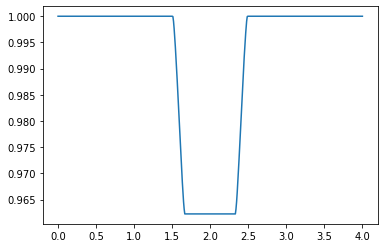

In [11]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,1)
fluxErr = 0.05*np.ones(1000)
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

In [21]:
cov = [0.25,0.25,0.1,np.std(times)/50, 0.05]
theta0 = [10,10,1,2,1]##Start with initial proposal
startTime = time.time()
positions, lnProbPos, acceptanceRatio = mhMcmc(theta0, cov,5000, times, flux, fluxErr)#3Sample
endTime = time.time()
print(endTime - startTime)
print(positions[
    -1])
print(acceptanceRatio)

/home/jbromley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


410.71459460258484
[10.75010847 16.66776766  0.89131069  1.98185787  0.53660598]
[0.     0.     0.     ... 0.3722 0.3722 0.3722]


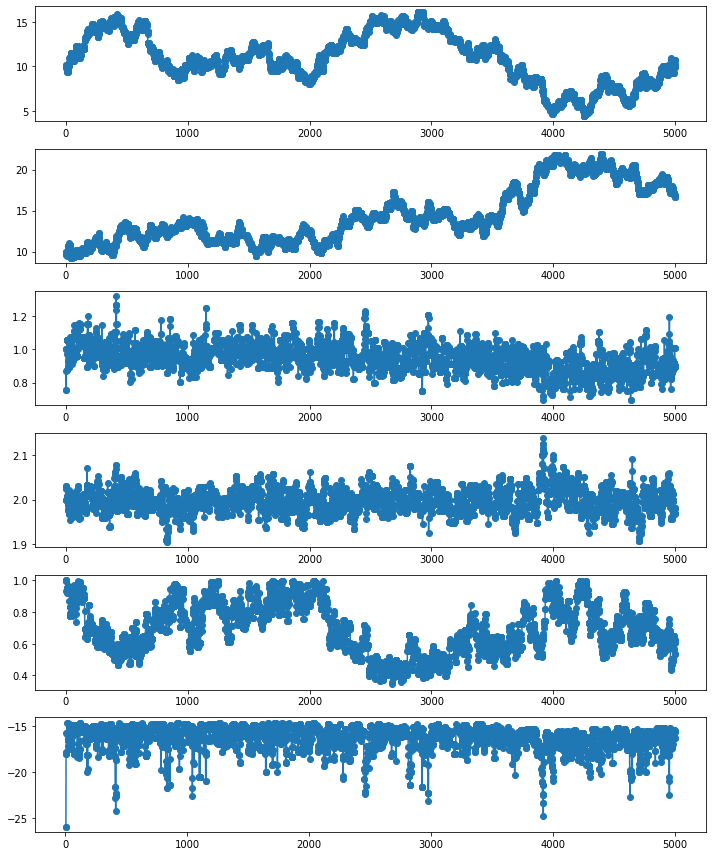

In [22]:
##Plotting the traces for the 4 sampled parameters
fig, ax = plt.subplots(6,1, figsize = (10,12))
for i in range(5):
    ax[i].plot(positions[:,i],'o-')
ax[5].plot(lnProbPos,'o-')

fig.tight_layout()
plt.show()

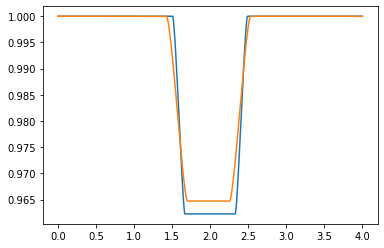

In [23]:
newFlux = transitSim(positions[-1][0],positions[-1][1],50,positions[-1][2],times,positions[-1][3],positions[-1][4])
fig = plt.subplot()
fig.plot(times, flux)
fig.plot(times, newFlux)
plt.show()